In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Prepare Data

In [3]:
from torch.utils.data import Subset
import numpy as np

transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize images to 32x32
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize images
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

def sample_dataset(dataset, num_samples_per_class=600, random_state=42):
    np.random.seed(random_state)  # Set the random state for reproducibility
    targets = np.array(dataset.targets)
    indices = []

    for class_label in range(10):  # MNIST has 10 classes
        class_indices = np.where(targets == class_label)[0]
        sampled_indices = np.random.choice(class_indices, num_samples_per_class, replace=False)
        indices.extend(sampled_indices)

    sampled_dataset = Subset(dataset, indices)
    return sampled_dataset

# Apply the sampling function to both the train and test datasets with a specified random state
trainset_sampled = sample_dataset(trainset, random_state=42)
testset_sampled = sample_dataset(testset, random_state=42)

# Then create DataLoaders for the sampled datasets
trainloader_sampled = DataLoader(trainset_sampled, batch_size=64, shuffle=True)
testloader_sampled = DataLoader(testset_sampled, batch_size=64, shuffle=False)

trainloader_sampled

100%|██████████| 9912422/9912422 [00:00<00:00, 221139166.33it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 34277219.53it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 82531491.54it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3403703.55it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



print(trainloader_sampled)

In [ ]:
trainloader_sampled

# Draw -- Helper func

In [4]:
def draw(num_epochs, train_losses, test_losses, train_accuracies, test_accuracies):
    epochs = range(1, num_epochs + 1)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, test_accuracies, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Test Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

def calculate_accuracy(y_pred, y_true):
    predicted = torch.argmax(y_pred, dim=1)
    correct = (predicted == y_true).float().sum()
    accuracy = correct / y_true.shape[0]
    return accuracy.item()


# CNN Implementation

In [5]:
# CNN
class VGG11(nn.Module):
    def __init__(self):
        super(VGG11, self).__init__()
        self.features = nn.Sequential(
            # 1
            nn.Conv2d(1, 64, kernel_size=3, padding=1),  # MNIST is grayscale, so 1 input channel
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            # 4
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 5
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            # 6
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 7
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            # 8
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            # Define the fully connected layers
            nn.Linear(512, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 10)  # Output layer for 10 classes
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the output for the fully connected layers
        x = self.classifier(x)
        return x

# model = VGG11()
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# train
def cnn_train(num_iter=100, train=trainloader_sampled):
    for epoch in range(num_iter):  # Loop over the dataset multiple times
        running_loss = 0.0
        tr_er, tr_lo, ts_er, ts_lo = [], [], [], []
        for i, data in enumerate(train, 0):
            inputs, labels = data
            optimizer.zero_grad()  # Zero the parameter gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize

            running_loss += loss.item()
            if i % 100 == 99:  # Print average loss every 100 mini-batches
                print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
                running_loss = 0.0

    print('Finished Training')

#cnn_train()


def cnn_tr(num_epochs = 20):
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in trainloader_sampled:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            correct_train += (torch.argmax(outputs, dim=1) == labels).float().sum()
            total_train += labels.size(0)

        train_loss = running_loss / len(trainloader_sampled)
        train_accuracy = correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy.item())

        model.eval()
        running_loss = 0.0
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for images, labels in testloader_sampled:
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                correct_test += (torch.argmax(outputs, dim=1) == labels).float().sum()
                total_test += labels.size(0)

        test_loss = running_loss / len(testloader_sampled)
        test_accuracy = correct_test / total_test
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy.item())

        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
    return num_epochs, train_losses, test_losses, train_accuracies, test_accuracies

# num_epochs, train_losses, test_losses, train_accuracies, test_accuracies = cnn_tr()
# draw(num_epochs, train_losses, test_losses, train_accuracies, test_accuracies)

# 3. Train w Adam

Epoch 1, Train Loss: 9.4919, Train Accuracy: 0.1558, Test Loss: 2.0183, Test Accuracy: 0.1947
Epoch 2, Train Loss: 2.0780, Train Accuracy: 0.1975, Test Loss: 1.9811, Test Accuracy: 0.2357
Epoch 3, Train Loss: 2.0854, Train Accuracy: 0.1977, Test Loss: 2.0206, Test Accuracy: 0.1920
Epoch 4, Train Loss: 2.1224, Train Accuracy: 0.1820, Test Loss: 2.6984, Test Accuracy: 0.1520
Epoch 5, Train Loss: 2.1777, Train Accuracy: 0.1913, Test Loss: 2.1894, Test Accuracy: 0.1452
Epoch 6, Train Loss: 2.0486, Train Accuracy: 0.1928, Test Loss: 1.9974, Test Accuracy: 0.2017
Epoch 7, Train Loss: 2.0467, Train Accuracy: 0.1937, Test Loss: 2.0093, Test Accuracy: 0.1947
Epoch 8, Train Loss: 2.0760, Train Accuracy: 0.1910, Test Loss: 2.0282, Test Accuracy: 0.1987
Epoch 9, Train Loss: 2.2385, Train Accuracy: 0.1823, Test Loss: 4.4828, Test Accuracy: 0.1228
Epoch 10, Train Loss: 2.1104, Train Accuracy: 0.1910, Test Loss: 2.2791, Test Accuracy: 0.1397
Epoch 11, Train Loss: 2.0881, Train Accuracy: 0.1967, Test 

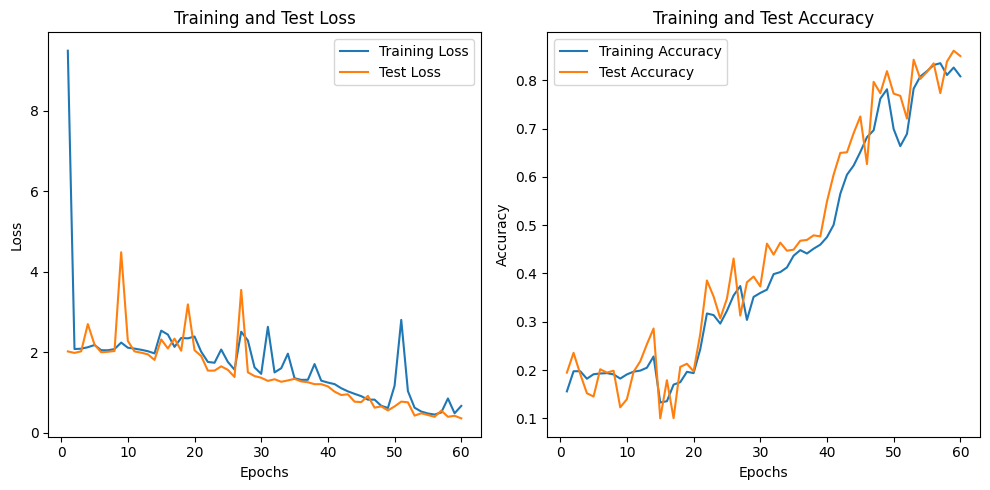

In [6]:
model = VGG11()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
num_epochs, train_losses, test_losses, train_accuracies, test_accuracies = cnn_tr(60)
draw(num_epochs, train_losses, test_losses, train_accuracies, test_accuracies)

# 4. Replace ReLU activation with Sigmoid

In [ ]:
# CNN
class VGG11_sgm(nn.Module):
    def __init__(self):
        super(VGG11_sgm, self).__init__()
        self.features = nn.Sequential(
            # 1
            nn.Conv2d(1, 64, kernel_size=3, padding=1),  # MNIST is grayscale, so 1 input channel
            nn.BatchNorm2d(64),
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.Sigmoid(),
            # 4
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 5
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.Sigmoid(),
            # 6
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 7
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.Sigmoid(),
            # 8
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            # Define the fully connected layers
            nn.Linear(512, 4096),
            nn.Sigmoid(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.Sigmoid(),
            nn.Dropout(0.5),
            nn.Linear(4096, 10)  # Output layer for 10 classes
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the output for the fully connected layers
        x = self.classifier(x)
        return x

model = VGG11_sgm()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# train
def cnn_tr(num_epochs = 20):
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in trainloader_sampled:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            correct_train += (torch.argmax(outputs, dim=1) == labels).float().sum()
            total_train += labels.size(0)

        train_loss = running_loss / len(trainloader_sampled)
        train_accuracy = correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy.item())

        model.eval()
        running_loss = 0.0
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for images, labels in testloader_sampled:
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                correct_test += (torch.argmax(outputs, dim=1) == labels).float().sum()
                total_test += labels.size(0)

        test_loss = running_loss / len(testloader_sampled)
        test_accuracy = correct_test / total_test
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy.item())

        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
    return num_epochs, train_losses, test_losses, train_accuracies, test_accuracies

num_epochs, train_losses, test_losses, train_accuracies, test_accuracies = cnn_tr()
draw(num_epochs, train_losses, test_losses, train_accuracies, test_accuracies)

Epoch 1, Train Loss: 2.6539, Train Accuracy: 0.0992, Test Loss: 2.4305, Test Accuracy: 0.1000
Epoch 2, Train Loss: 2.4714, Train Accuracy: 0.1062, Test Loss: 2.4366, Test Accuracy: 0.1000
Epoch 3, Train Loss: 2.3034, Train Accuracy: 0.1382, Test Loss: 2.1063, Test Accuracy: 0.1895


# 5. Remove Dropout from your CNN and train it again.

Epoch 1, Train Loss: 0.4640, Train Accuracy: 0.8533, Test Loss: 0.1481, Test Accuracy: 0.9555
Epoch 2, Train Loss: 0.1010, Train Accuracy: 0.9683, Test Loss: 0.0867, Test Accuracy: 0.9723
Epoch 3, Train Loss: 0.0517, Train Accuracy: 0.9850, Test Loss: 0.0588, Test Accuracy: 0.9805
Epoch 4, Train Loss: 0.0310, Train Accuracy: 0.9900, Test Loss: 0.1476, Test Accuracy: 0.9595
Epoch 5, Train Loss: 0.0241, Train Accuracy: 0.9922, Test Loss: 0.0566, Test Accuracy: 0.9840
Epoch 6, Train Loss: 0.0119, Train Accuracy: 0.9967, Test Loss: 0.1622, Test Accuracy: 0.9613
Epoch 7, Train Loss: 0.0167, Train Accuracy: 0.9952, Test Loss: 0.0797, Test Accuracy: 0.9803
Epoch 8, Train Loss: 0.0043, Train Accuracy: 0.9990, Test Loss: 0.0409, Test Accuracy: 0.9887
Epoch 9, Train Loss: 0.0093, Train Accuracy: 0.9972, Test Loss: 0.0545, Test Accuracy: 0.9865
Epoch 10, Train Loss: 0.0080, Train Accuracy: 0.9977, Test Loss: 0.0456, Test Accuracy: 0.9862
Epoch 11, Train Loss: 0.0045, Train Accuracy: 0.9985, Test 

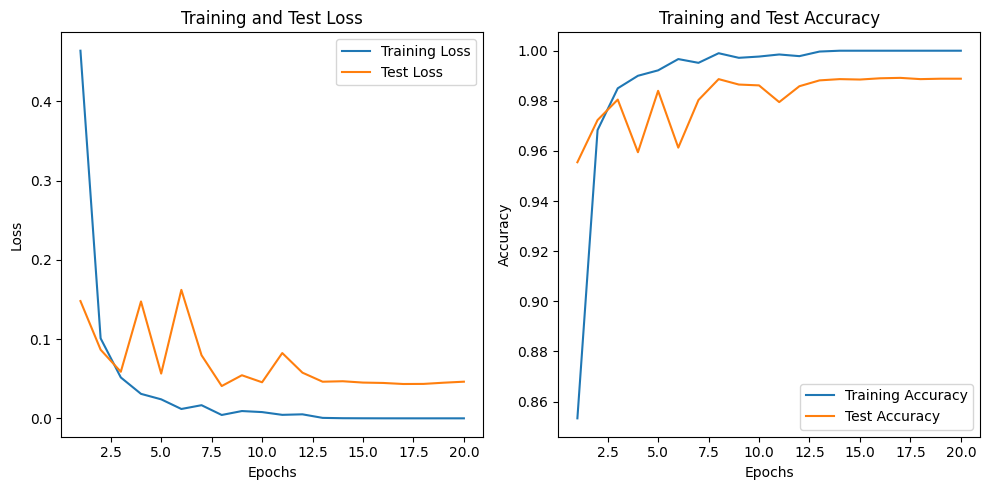

In [7]:
# CNN
class VGG11_wo_dro(nn.Module):
    def __init__(self):
        super(VGG11_wo_dro, self).__init__()
        self.features = nn.Sequential(
            # 1
            nn.Conv2d(1, 64, kernel_size=3, padding=1),  # MNIST is grayscale, so 1 input channel
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            # 4
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 5
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            # 6
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 7
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            # 8
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            # Define the fully connected layers
            nn.Linear(512, 4096),
            nn.ReLU(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, 10)  # Output layer for 10 classes
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the output for the fully connected layers
        x = self.classifier(x)
        return x

model = VGG11_wo_dro()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# train
def cnn_train(num_iter=100, train=trainloader_sampled):
    for epoch in range(num_iter):  # Loop over the dataset multiple times
        running_loss = 0.0
        tr_er, tr_lo, ts_er, ts_lo = [], [], [], []
        for i, data in enumerate(train, 0):
            inputs, labels = data
            optimizer.zero_grad()  # Zero the parameter gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize

            running_loss += loss.item()
            if i % 100 == 99:  # Print average loss every 100 mini-batches
                print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
                running_loss = 0.0

    print('Finished Training')

#cnn_train()


def cnn_tr(num_epochs = 20):
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in trainloader_sampled:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            correct_train += (torch.argmax(outputs, dim=1) == labels).float().sum()
            total_train += labels.size(0)

        train_loss = running_loss / len(trainloader_sampled)
        train_accuracy = correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy.item())

        model.eval()
        running_loss = 0.0
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for images, labels in testloader_sampled:
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                correct_test += (torch.argmax(outputs, dim=1) == labels).float().sum()
                total_test += labels.size(0)

        test_loss = running_loss / len(testloader_sampled)
        test_accuracy = correct_test / total_test
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy.item())

        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
    return num_epochs, train_losses, test_losses, train_accuracies, test_accuracies

num_epochs, train_losses, test_losses, train_accuracies, test_accuracies = cnn_tr()
draw(num_epochs, train_losses, test_losses, train_accuracies, test_accuracies)

# Exe 3: MLP

Epoch 1, Train Loss: 0.5449, Train Accuracy: 0.8325, Test Loss: 0.3031, Test Accuracy: 0.9097
Epoch 2, Train Loss: 0.2323, Train Accuracy: 0.9357, Test Loss: 0.2425, Test Accuracy: 0.9235
Epoch 3, Train Loss: 0.1608, Train Accuracy: 0.9523, Test Loss: 0.2266, Test Accuracy: 0.9297
Epoch 4, Train Loss: 0.1178, Train Accuracy: 0.9680, Test Loss: 0.2025, Test Accuracy: 0.9398
Epoch 5, Train Loss: 0.0887, Train Accuracy: 0.9773, Test Loss: 0.1826, Test Accuracy: 0.9415
Epoch 6, Train Loss: 0.0610, Train Accuracy: 0.9847, Test Loss: 0.1876, Test Accuracy: 0.9413
Epoch 7, Train Loss: 0.0451, Train Accuracy: 0.9910, Test Loss: 0.1918, Test Accuracy: 0.9398
Epoch 8, Train Loss: 0.0351, Train Accuracy: 0.9930, Test Loss: 0.1698, Test Accuracy: 0.9492
Epoch 9, Train Loss: 0.0247, Train Accuracy: 0.9955, Test Loss: 0.1558, Test Accuracy: 0.9520
Epoch 10, Train Loss: 0.0210, Train Accuracy: 0.9963, Test Loss: 0.1557, Test Accuracy: 0.9527
Epoch 11, Train Loss: 0.0136, Train Accuracy: 0.9992, Test 

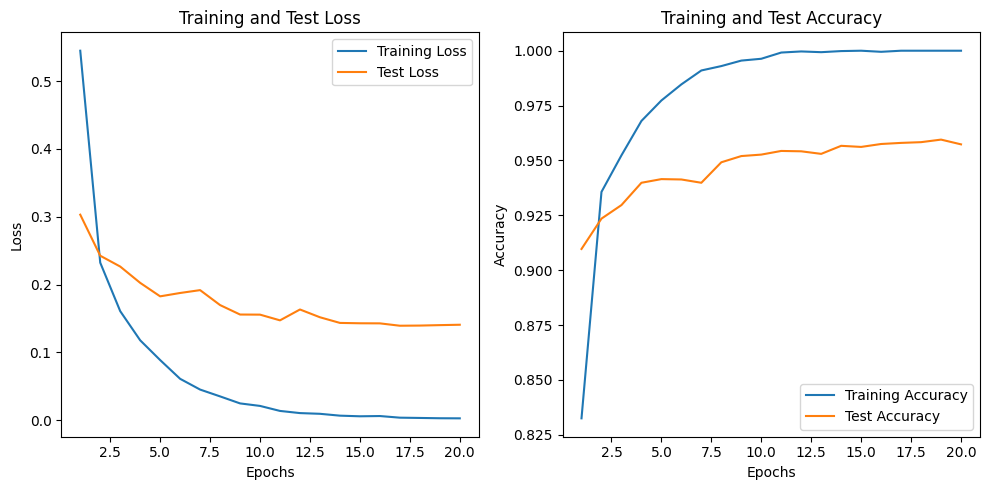

In [8]:
# Prepare the Dataset
transform_3 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset3 = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_3)
trainloader = torch.utils.data.DataLoader(trainset3, batch_size=64, shuffle=True)

testset3 = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_3)
testloader = torch.utils.data.DataLoader(testset3, batch_size=64, shuffle=False)

def sample_dataset(dataset, num_samples_per_class=600, random_state=42):
    np.random.seed(random_state)  # Set the random state for reproducibility
    targets = np.array(dataset.targets)
    indices = []

    for class_label in range(10):  # MNIST has 10 classes
        class_indices = np.where(targets == class_label)[0]
        sampled_indices = np.random.choice(class_indices, num_samples_per_class, replace=False)
        indices.extend(sampled_indices)

    sampled_dataset = Subset(dataset, indices)
    return sampled_dataset

# Apply the sampling function to both the train and test datasets with a specified random state
trainset_sampled3 = sample_dataset(trainset3, random_state=42)
testset_sampled3 = sample_dataset(testset3, random_state=42)

# Then create DataLoaders for the sampled datasets
trainloader_sampled3 = DataLoader(trainset_sampled3, batch_size=64, shuffle=True)
testloader_sampled3 = DataLoader(testset_sampled3, batch_size=64, shuffle=False)

# Define the Model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 512)
        self.bn = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):
        x = x.view(-1, 784)  # Flatten the input images
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.bn(self.fc2(x)))
        x = self.fc3(x)
        return x


def mlp_tr(num_epochs = 20, trainloader_sampled=trainloader_sampled3, testloader_sampled=testloader_sampled3):
    model = MLP()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in trainloader_sampled:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            correct_train += (torch.argmax(outputs, dim=1) == labels).float().sum()
            total_train += labels.size(0)

        train_loss = running_loss / len(trainloader_sampled)
        train_accuracy = correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy.item())

        model.eval()
        running_loss = 0.0
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for images, labels in testloader_sampled:
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                correct_test += (torch.argmax(outputs, dim=1) == labels).float().sum()
                total_test += labels.size(0)

        test_loss = running_loss / len(testloader_sampled)
        test_accuracy = correct_test / total_test
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy.item())

        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
    return num_epochs, train_losses, test_losses, train_accuracies, test_accuracies

num_epochs, train_losses, test_losses, train_accuracies, test_accuracies = mlp_tr()
draw(num_epochs, train_losses, test_losses, train_accuracies, test_accuracies)

